# Switching multi-armed bandit

The switching bandits are a variant of dynamic multi-armed bandits in which reward probability $p_{t, l}$ changes suddenly but is otherwise constant. Starting with the stationary model described in stationary_bandits_comparison.ipynb we will introduce reward probability changes as sudden switches in the arm associated with highest reward probability. 

At each time step the arm associated with the highest reward probability would either stay unchanged with probability $1-\rho$ or associated with another randomly selected arm with with probability $\rho$.

The highest reward probability will be set to $p_{max} = \epsilon + \frac{1}{2}$ and all other arms will be associated with $p=\frac{1}{2}$. This way three parameters define difficulty of inferring the best arm, $\epsilon$ the expected reward bonus, $\rho$ the transition probability, and $K$ the number of arms.

In [1]:
import numpyro as npyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random, lax, nn, ops
from collections import defaultdict

from opt_einsum import contract

import matplotlib.pyplot as plt
import seaborn as sns

from jupyterthemes import jtplot

sns.set(style="ticks", context="talk", color_codes=True)
jtplot.style(theme='monokai', ticks=True, grid=False)
plt.rcParams.update({
    'axes.spines.right': False, 
    'axes.spines.top': False, 
    'lines.linewidth': 2., 
    'axes.xmargin': 0.01, 
    'savefig.dpi': 300,
})

%matplotlib inline

def log(x):
    return jnp.nan_to_num(jnp.log(x))

def einsum(*args):
    return contract(*args, backend="jax")

In [2]:
def process(rng_key, t, choices, states, B=None, K=10, **kwargs):
    
    if B is not None:
        probs = B[states]
    else:
        probs = jnp.ones(K)/K
    
    N = len(choices)
        
    rng_key, _rng_key = random.split(rng_key)
    new_states = random.categorical(_rng_key, log(probs))
    
    rng_key, _rng_key = random.split(rng_key)
    reward_probs = .5 + eps * jnp.eye(K)[states]
    outcomes = random.bernoulli(_rng_key, reward_probs, shape=(N, K))
    
    return outcomes, new_states

def simulator(process, params, seed, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process( _rng_key, t, choices, states, **params)
        
        return (rng_key, states, choices), {'rewards': outcomes, 'states': states}
    
    rng_key = random.PRNGKey(seed)
    states = jnp.zeros(1, dtype=jnp.int32)
    choices = jnp.zeros(N, dtype=jnp.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), jnp.arange(T))
    
    I = jnp.eye(params['K'])    
    probs = .5 + params['eps'] * I[sequence['states'][..., 0]]
    probs0 = .5 + params['eps'] * I[states]
    
    sequence['probs'] = jnp.concatenate([probs0, probs], 0)[:-1]
    
    return sequence

In [3]:
K = 3
eps = .25
rho = .01
seed = 12345

B = (1 - rho) * jnp.eye(K) + rho * (jnp.ones((K, K)) - jnp.eye(K))/(K-1)

params = {
    'K': K,
    'eps': eps,
    'B': B
}

sequence = simulator(process, params, seed, T=1000)

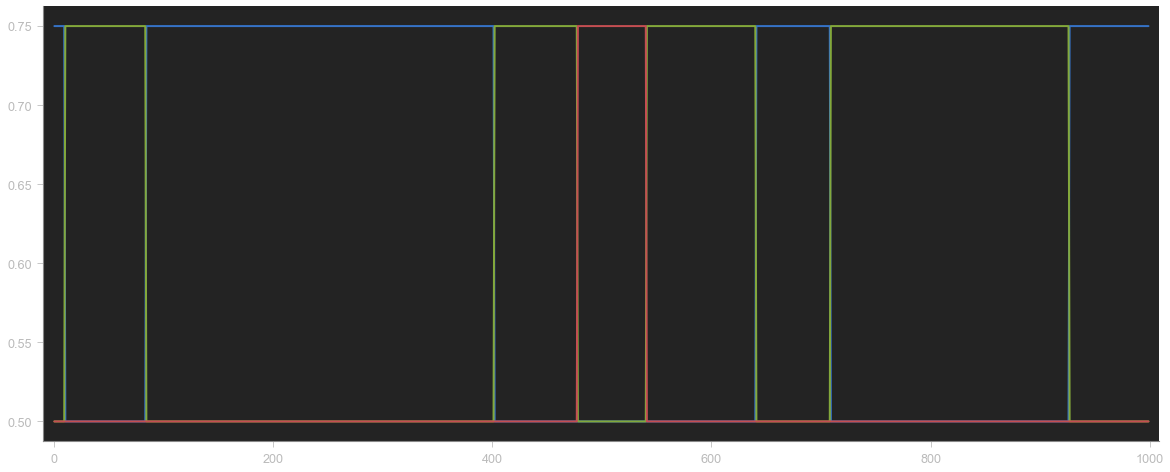

In [66]:
plt.figure(figsize=(20, 8))
plt.plot(sequence['probs']);

Lets assume that reward probability can have only D discrete values, for example 

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$.

Hence if we associate reward probabilities of each arm with descrete hidden states $k_{t,l}$ we can describe the whole problem as a hierarchical hidden markov model. In this case the state transition matrix is given as 

$$ p(\vec{k}_{t,l}|\vec{k}_{t-1, l}, j_{t-1}=0) = \prod_{l=1}^K p(k_{t,l}|k_{t-1,l}, j_{t-1}=0) = \prod_{l=1}^K I_D$$

that is, states do not change in the absence of a change point, and

$$ p(\vec{k}_{t,l}|\vec{k}_{t-1, l}, j_{t-1}=1) = \prod_{l=1}^K p(k_{t,l}|k_{t-1,l}, j_{t-1}=1) = \prod_{l=1}^K \frac{1}{D-1} \left( J_{D} - I_D \right) $$

where $J_D$ stands for a D-dimensional matrix of ones, and $I_D$ for a D-dimensional identity matrix.

This way one can define an exact update of beliefs using Bayes rule

$$ p(\vec{k}_t, j_t|\vec{o}_{1:t}) \propto p(\vec{o}_t|\vec{k}_t)p(\vec{k}_t,j_t|\vec{o}_{1:t-1})$$

where 

$$ p(\vec{o}_t|\vec{k}_t) = \prod_{l=1}^K p(o_{t,l}|k_{t,l}) = \prod_{l=1}^K P(k_{t,l})^{o_{t,l}}\left( 1-P(k_{t,l}) \right)^{1-o_{t,l}}$$

The above observation likelihood would correspond to the case when the agent can sample outcomes from all arms at the same time. However, we are considering the case when on any trial only one arm can be sampled. We will associate a choice of an agent to sample from $l$th arm at trial $t$ with as another random variable $s_t=l$, where

$$ p(s_t|s_{t-1}, a_t) = p(s_t|a_t) = \delta_{s_t, a_t}$$
where $a_t$ denotes a choice at trial $t$. Finally, sampling from the $l$th arm corresponds with observing an outcome $o_{t,l}$ with underlying probability $p_{t,l}$ and a outcomes from all other arms with probability $1/2$, for all $m\neq l$. Hence, we can define the observation likelihood as 

$$ p(\vec{o}_t|\vec{k}_t, s_t=l) = P(k_{t,l})^{o_{t,l}}\left( 1-P(k_{t,l}) \right)^{1-o_{t,l}} \prod_{m \neq l} \frac{1}{2}^{1-o_{t,m} + o_{t,m}} $$

We will assume that the choice states $s_t$ are directly observable, hence

$$ p(o^s_t = o|s_t=l) = \delta_{o, l}$$

In [4]:
class Simulator(object):
    
    def __init__(self, process, learning, selection, params, N=10, T=1000, K=10):
        
        self.N = N  # number of parallel runs
        self.T = T  # number of trials
        self.K = K  # number of arms
        
        self.I = jnp.eye(K)
        
        self.process = process  # generative process
        self.learning = learning  # learning alogrithm 
        self.selection = selection  # action selection algorithm
        
        self.params = params  # parameters of the generative model and process
        
        rho = self.params['rho']
        B = (1 - rho) * jnp.eye(K) + rho * (jnp.ones((K, K)) - jnp.eye(K))/(K-1)
        self.params['B'] = B
        self.params['K'] = K
        
    def scan(self, func, carry, iterator):
        
        sequence = []
        for n in iterator:
            carry, res = func(carry, n)
            sequence.append(res)
        
        final = defaultdict(lambda: [])
        for seq in sequence:
            for key in seq.keys():
                final[key].append(seq[key])
        
        for key in final.keys():
            final[key] = jnp.stack(final[key], 0)
        
        return final
        
    def run(self, prior, seed=0):
        def sim_fn(carry, t):
            rng_key, states, prior = carry

            rng_key, _rng_key = random.split(rng_key)
            choices = self.selection(_rng_key, prior, t=t, **self.params)

            rng_key, _rng_key = random.split(rng_key)
            outcomes, states = self.process(_rng_key, t, choices, states, **self.params)
            
            posterior = self.learning(outcomes, choices, prior, **self.params)

            return (rng_key, states, posterior), {'outcomes': outcomes, 
                                                  'states': states,
                                                  'choices': choices,
                                                  'beliefs': posterior}

        rng_key = random.PRNGKey(seed)
        states = jnp.zeros(1, dtype=jnp.int32)
        sequence = self.scan(sim_fn, (rng_key, states, prior), jnp.arange(self.T))
    
        probs = .5 + self.params['eps'] * self.I[sequence['states'][..., 0]]
        probs0 = .5 + self.params['eps'] * self.I[states]

        sequence['probs'] = jnp.concatenate([probs0, probs], 0)[:-1]
        
        return sequence
    
def calc_probs(choices, true_probs, N):
    probs = jnp.stack([lax.index_take(true_probs, [jnp.arange(T), choices[:, n]], (0, 1)) for n in range(N)], 0)
    return probs

In [5]:
from itertools import product
D = 10
pj_j = jnp.array([[1 - rho, rho], [1, 0]])

args = [jnp.eye(D)] * K
tm1 = einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

args = [(jnp.ones((D,D)) - jnp.eye(D))/(D-1)] * K
tm2 = einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

pk_kj = jnp.stack([tm1, tm2], 0)

po_k = jnp.array(list(product(jnp.arange(1/(2*D), 1., 1/D), repeat=K)))
po_ks = jnp.where(jnp.eye(K, dtype=jnp.int32)[:, None], po_k, .5)

log_po_ks = jnp.log(po_ks)
log_1_po_ks = jnp.log(1 - po_ks)

def learning(outcomes, choices, priors, **kwargs):
    
    pred = einsum('iks,ij,nik->njs', pk_kj, pj_j, priors)
        
    o = outcomes[:, None]
    lklh = jnp.exp((log_po_ks[choices] * o + log_1_po_ks[choices] * (1 - o)).sum(-1))
    
    joint = lklh[:, None] * pred
    N = choices.shape[0]
    norm = joint.reshape(N, -1).sum(-1).reshape(N, 1, 1)
    
    return joint/norm

def optimistic_selection(rng_key, beliefs, **kwargs):
    #Optimistic thompson sampling
    marg = einsum('n...k->nk', beliefs)
    sample = random.categorical(rng_key, jnp.log(marg))
    mean_probs = einsum('nk,ko->no', marg, po_k)
    outcome_probs = po_k[sample] # map states to underlying outcome probabilities of different arms
    outcome_probs = jnp.where(outcome_probs > mean_probs, outcome_probs, mean_probs)
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

H_ks = - jnp.sum(jnp.nan_to_num(log_po_ks) * po_ks, -1) \
       - jnp.sum(jnp.nan_to_num(log_1_po_ks) * (1 - po_ks), -1)

def sup_selection(rng_key, beliefs, gamma=15, lam=1., **kwargs):
    # active inference
    marg = einsum('n...k->nk', beliefs)
    H_a = einsum('nk,ak->na', marg, H_ks)
    
    po_a = einsum('nk,ako->nao', marg, po_ks)
    log_po_a = log(po_a)
    log_1_po_a = log(1 - po_a)
    
    KL_a = jnp.sum(po_a * log_po_a + (1 - po_a) * log_1_po_a - lam * (2 * po_a - 1), -1)
    
    S_a = KL_a + H_a
    
    choices = random.categorical(rng_key, - gamma * S_a) # sample choices
    return choices

In [67]:
N = 100
T = 1000

sequence_states = []
labels_states = ['O-TS', 'S-AI']

args = [jnp.array([0., 1.])] + [jnp.ones(D)/D]*K
prior = einsum('j,i,l,m->jilm', *args).reshape(2, -1)[None].repeat(N, 0)

rho = .01
params['rho'] = rho
params['lam'] = 1.
params['gamma'] = 20.

for selection in [optimistic_selection,
                  sup_selection]:
    sim = Simulator(process, learning, selection, params, N=N, T=T, K=K)
    sequence_states.append(sim.run(prior, seed=seed))

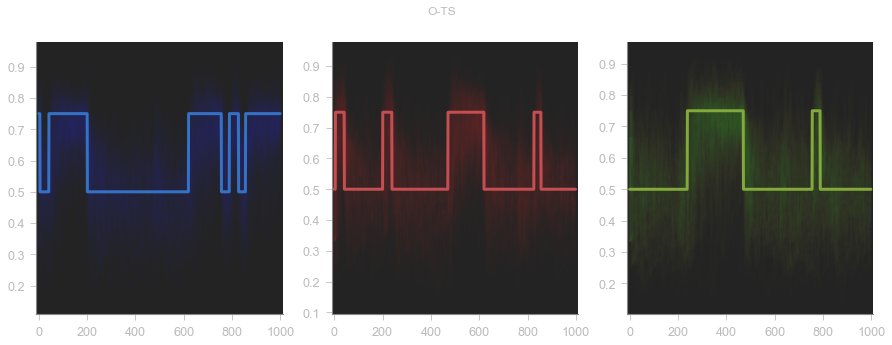

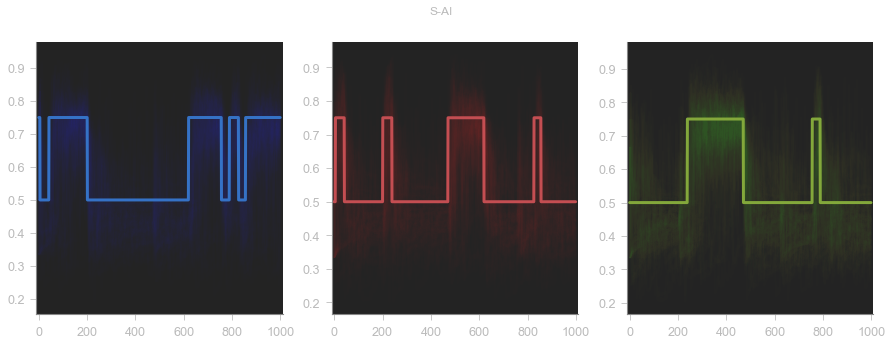

In [68]:
# plot beliefs which were inferred using discretized hidden states
for i, s in enumerate(sequence_states):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    post = s['beliefs']
    post_probs = einsum('tnk,lko->tnlo', post.sum(-2), po_ks)
    true_probs = s['probs']

    colours = ['b', 'r', 'g']
    for k in range(K):
        axes[k].plot(post_probs[..., k, k], c=colours[k], alpha=.01)
        axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    fig.suptitle(labels_states[i])
    plt.show()

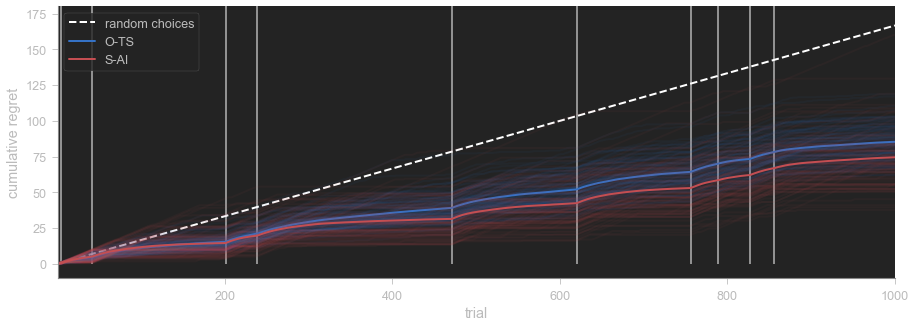

In [70]:
states_probs = [calc_probs(s['choices'], s['probs'], s['choices'].shape[-1]) for s in sequence_states]
max_probs = .5 + params['eps']

trials = jnp.arange(1, T + 1)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

changes = jnp.concatenate([jnp.zeros(1), jnp.abs(jnp.diff(true_probs.argmax(-1)))], -1)
plt.vlines(jnp.nonzero(changes), 0, 200, 'w', alpha=.5)

line_colors = ['b', 'r']

plt.plot(trials, trials * params['eps'] * (K-1)/K, 'w--', label='random choices', lw=2)

for i,probs in enumerate(states_probs):
    regret = jnp.cumsum(max_probs - probs, -1).T
    plt.plot(trials, regret, line_colors[i], alpha=.05);
    plt.plot(trials, regret.mean(-1), line_colors[i], label=labels_states[i], lw=2)

plt.xlim(1, T)
plt.ylim(-10, 180)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend(loc=0);

Vertical lines denote change points.

In [6]:
from jax.scipy.special import digamma 
from scipy.special import betaincinv

def parametric_learning(outcomes, choices, beliefs, kappa=.95, **kwargs):
    N, K = outcomes.shape
    
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    select_obs = jnp.eye(K)[choices]
    
    alpha_new = alpha_t + select_obs * outcomes
    beta_new = beta_t + select_obs * (1 - outcomes)
    
    return jnp.stack([kappa * alpha_new + 1 - kappa, kappa * beta_new + 1 - kappa], -1)

def parametric_bucb(rng_key, beliefs, **kwargs):
    # bayesian ucb algorithm 
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    t = kwargs['t']
    
    perc = 1. - 1./(1. + t)
    Q = betaincinv(alpha_t, beta_t, perc)

    lQ = jnp.log(Q)
    
    return random.categorical(rng_key, 1e3*(lQ - lQ.mean(-1, keepdims=True)))

def parametric_optimistic(rng_key, beliefs, **kwargs):
    #Optimistic thompson sampling
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    mu_t = alpha_t/(alpha_t + beta_t)
    theta_sample = random.beta(rng_key, alpha_t, beta_t)
    
    return jnp.where(theta_sample > mu_t, theta_sample, mu_t).argmax(-1)

def parametric_sup(rng_key, beliefs, lam=1., gamma=15., **kwargs):
    # active inference
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t/nu_t
    
    D_KL_a = - lam * (2 * mu_t - 1) + mu_t * log(mu_t) + (1-mu_t) * log(1-mu_t)
    
    H_a = - mu_t * digamma(alpha_t + 1) - (1-mu_t) * digamma(beta_t + 1) + digamma(nu_t + 1)
    
    return random.categorical(rng_key, - gamma * (D_KL_a + H_a)) # sample choices

def parametric_app(rng_key, beliefs, lam=1., gamma=15., **kwargs):
    # active inference
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t/nu_t
    
    S_a = - lam * ( 2 * mu_t - 1) - 1/(2 * nu_t) 
    return random.categorical(rng_key, - gamma * (S_a - S_a.mean(-1, keepdims=True))) # sample choices

In [71]:
K = 3
N = 100
T = 1000
seed = 12345
sequences = []
labels_parametric = ['Par-O-TS', 'Par-B-UCB', 'Par-A-AI']

params = {
    'kappa': .95,
    'lam': 1.,
    'gamma': 20.,
    'eps': .25,
    'rho': .01,
    'K': K
}

prior = jnp.stack([jnp.ones((N, K)), jnp.ones((N, K))], -1)
sequence_parametric = []
for selection in [parametric_optimistic,
                  parametric_bucb,
                  parametric_app]:
    
    sim = Simulator(process, parametric_learning, selection, params, N=N, T=T, K=K)
    sequence_parametric.append(sim.run(prior, seed=seed))

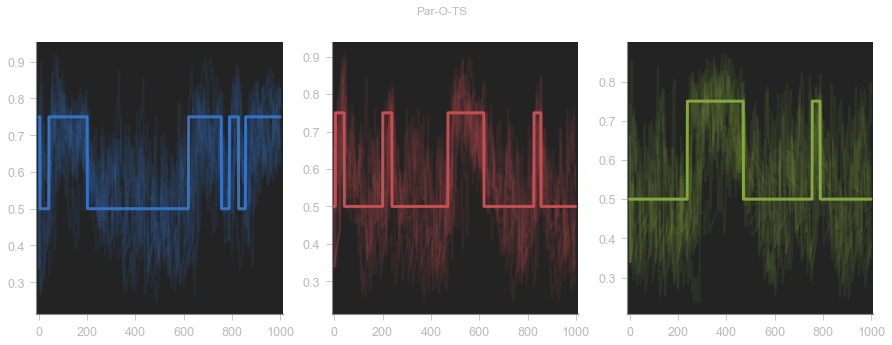

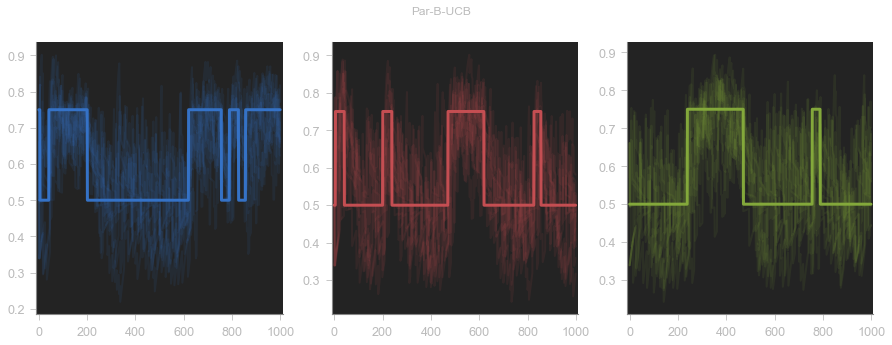

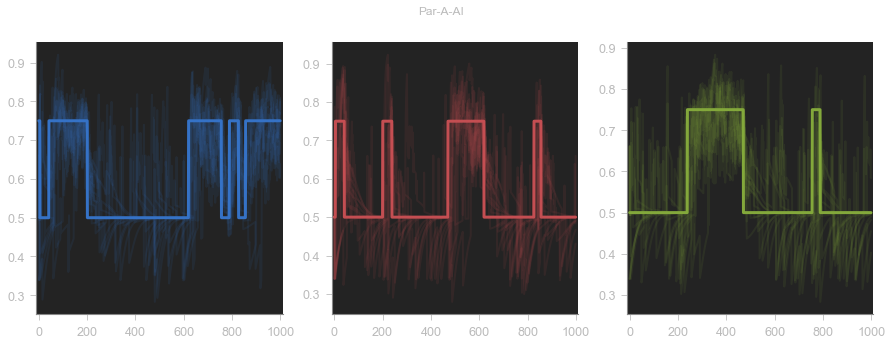

In [95]:
# plot beliefs which were inferred using parametric learning
for i,s in enumerate(sequence_parametric):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    post = s['beliefs']
    post_probs = post[..., 0]/(post[..., 0] + post[..., 1])
    true_probs = s['probs']

    colours = ['b', 'r', 'g']
    for k in range(K):
        axes[k].plot(post_probs[:, ::10, k], c=colours[k], alpha=.1)
        axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    fig.suptitle(labels_parametric[i])
    plt.show()

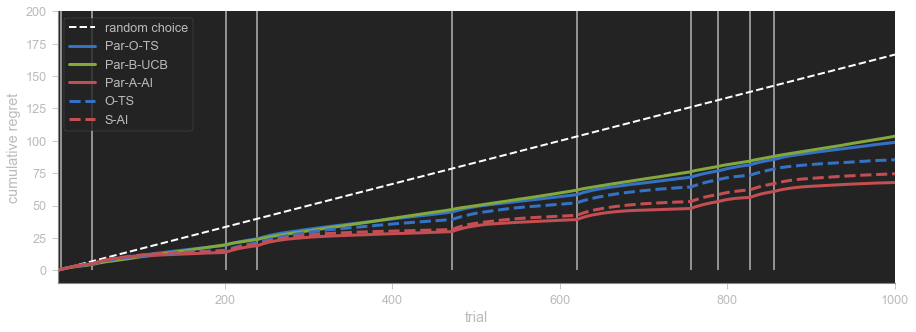

In [75]:
parametric_probs = [calc_probs(s['choices'], s['probs'], s['choices'].shape[-1]) for s in sequence_parametric]
max_probs = .5 + params['eps']

trials = jnp.arange(1, T+1)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

changes = jnp.concatenate([jnp.zeros(1), jnp.abs(jnp.diff(true_probs.argmax(-1)))], -1)
plt.vlines(jnp.nonzero(changes), 0, 200, 'w', alpha=.5)

line_colors = ['b', 'g', 'r']
K = params['K']
plt.plot(trials, trials * params['eps']*(K - 1)/K, 'w--', label='random choice')
for i, probs in enumerate(parametric_probs):
    regret = jnp.cumsum(max_probs - probs, -1).T
#     plt.plot(trials, regret, line_colors[i], alpha=.05);
    plt.plot(trials, regret.mean(-1), line_colors[i], label=labels_parametric[i], lw=3)

line_colors = ['b', 'r']
for i, probs in enumerate(states_probs):
    regret = jnp.cumsum(max_probs - probs, -1).T
    plt.plot(trials, regret.mean(-1), line_colors[i], linestyle='--', label=labels_states[i], lw=3)
    
plt.xlim(1, T)
plt.ylim(top=200)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend(loc=2);

In [7]:
N = 100
T = 1000
seed = 12345

sequences = defaultdict(lambda: {})
for K in [10, 20, 40]:
    sequences[K] = defaultdict(lambda: [])
    for R in [1, 2, 4]:
        labels_parametric = ['O-TS', 'B-UCB', 'A-AI']

        params = {
            'kappa': .95,
            'lam': 1.,
            'gamma': 20.,
            'eps': .25,
            'rho': R/100,
        }

        prior = jnp.stack([jnp.ones((N, K)), jnp.ones((N, K))], -1)
        for selection in [parametric_optimistic,
                          parametric_bucb,
                          parametric_app]:

            sim = Simulator(process, parametric_learning, selection, params, N=N, T=T, K=K)
            sequences[K][R].append(sim.run(prior, seed=seed))

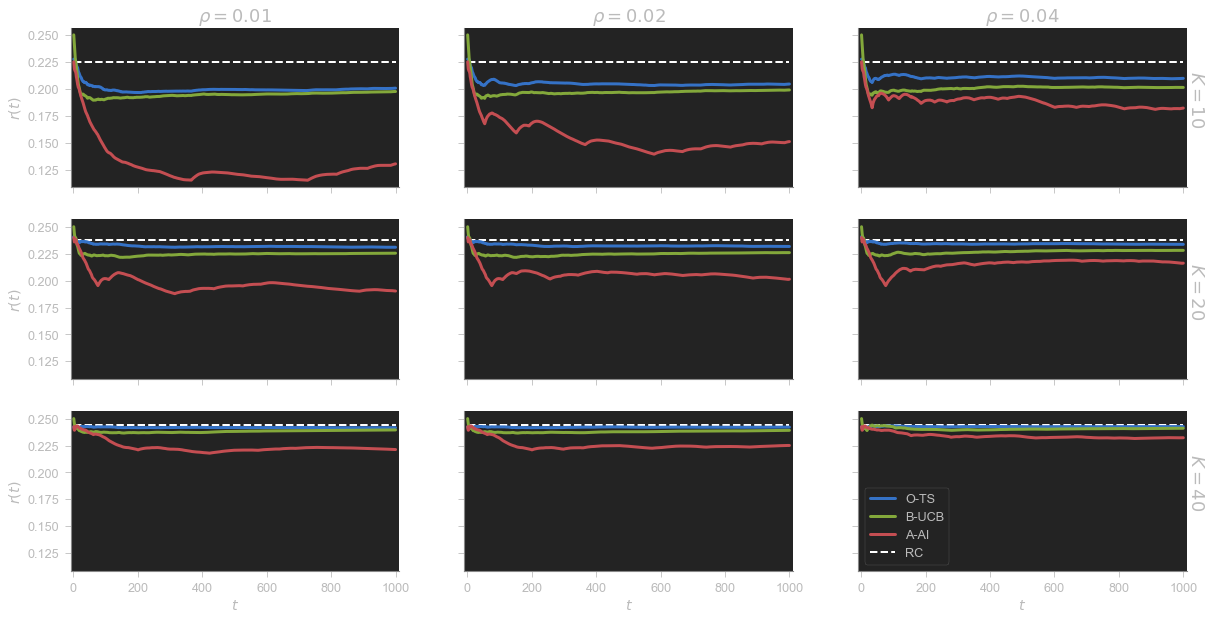

In [17]:
max_probs = .5 + params['eps']
trials = jnp.arange(1, T+1)
fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey=True)

for i, K in enumerate(sequences.keys()):
    for j, R in enumerate(sequences[K].keys()):
        est_probs = [calc_probs(s['choices'], s['probs'], s['choices'].shape[-1]) for s in sequences[K][R]]
        true_probs = [s['probs'] for s in sequences[K][R]]
        
#         changes = jnp.concatenate([jnp.zeros(1), jnp.abs(jnp.diff(true_probs[0].argmax(-1)))], -1)
#         axes[i, j].vlines(jnp.nonzero(changes), 0, params['eps']*(K - 1)/K, 'w', alpha=.5)

        line_colors = ['b', 'g', 'r']
        axes[i, j].hlines(params['eps']*(K - 1)/K, trials[0], trials[-1], color='w', linestyle='--', label='RC')
        for k, probs in enumerate(est_probs):
            regret = jnp.cumsum(max_probs - probs, -1).T
            axes[i, j].plot(trials, regret.mean(-1)/trials, line_colors[k], label=labels_parametric[k], lw=3)
        
        if i == 2:
            axes[i, j].set_xlabel(r'$t$')
        if i == 0:
            axes[i, j].set_title(r'$\rho={}$'.format(R/100.), fontsize=18)
    axes[i, -1].text(1., .4, r'$K={}$'.format(K), transform=axes[i, -1].transAxes, fontsize=18, rotation=-90)
    axes[i, 0].set_ylabel(r'$r(t)$')

plt.legend();
fig.savefig('switching_reg_rate.svg', transparent=True, bbox_inches='tight')

Above we have assumed that the agent already knows the change point probability, however in general this will be a hidden quantity for the agent. Here we will add another level of the hierarchy in which agent infers the change point probability. Similar to the observation likelihoods, we can discretise the change point probability $\rho$ and assume that 

$$ \rho \in R = \left\{ \frac{1}{2M}, \ldots, 1-\frac{1}{M} \right\}, \qquad |R| = M$$

We will associate different possible values with descrete hidden states $r_t$, and express the change point transition matrix as 

\begin{equation}
    p(j_{t}=j|j_{t-1}, r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1,l} = 1  \\
        \rho_r^{j}(1-\rho_r)^{1-j} & \textrm{for } j_{t-1,l} = 0
    \end{array}
    \right.
\end{equation}

and the $r_t$ transition probabability as a 1D random walk

\begin{equation}
    p(r_t=q|r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{q, r} & \textrm{with Pr. } 1 - \eta  \\
        \delta_{q, r + 1} & \textrm{with Pr. } \frac{\eta}{2} \\
        \delta_{q, r - 1} & \textrm{with Pr. } \frac{\eta}{2}
    \end{array}
    \right.
\end{equation}

The belief update becomes

$$ p(\vec{k}_t, j_t, r_t|\vec{o}_{1:t}, a_{1:t}) \propto p(\vec{o}_t|\vec{k}_t, a_t)p(\vec{k}_t,j_t, r_t|o_{1:t-1})$$

where we have marginlised out $s_t$. We will assume a priory a bias toward small change probabilities, hence 

$$ p(r_0 = r) \propto e^{- r} $$

In [134]:
M = 50

eta = 0
pr_r = (1 - eta) * jnp.eye(M) + eta * (jnp.diag(jnp.ones(M-1), 1) + jnp.diag(jnp.ones(M-1), -1))/2
pr_r = ops.index_update(pr_r, ops.index[[0, -1], [1, -2]], eta)

rho = jnp.arange(1/(2*M), .5+1/(2*M), 1/(2*M))
stay = jnp.stack([1 - rho, rho], -1)
change = jnp.array([1., 0.])[None].repeat(M, -2)
pj_jr = jnp.stack([stay, change], -2)

def learning(outcomes, choices, priors, **kwargs):
    N, K = outcomes.shape
    pred = einsum('iks,rij,rq,nrik->nqjs', pk_kj, pj_jr, pr_r, priors)
    
    o = outcomes[:, None]
    lklh = jnp.exp((log_po_ks[choices] * o + log_1_po_ks[choices] * (1 - o)).sum(-1))
    
    joint = lklh[:, None, None] * pred
    norm = joint.reshape(N, -1).sum(-1).reshape(N, 1, 1, 1)
    
    return joint/norm

In [ ]:
N = 10
K = 3
T = 1000

sequence_states2 = []
labels_states2 = ['ADA-O-TS', 'ADA-S-AI']

args = [jnp.exp(- 1 * jnp.arange(M))/jnp.exp(- 1 * jnp.arange(M)).sum(), jnp.array([0., 1.])] + [jnp.ones(D)/D]*K
prior = einsum('i,j,k,l,m->ijklm', *args).reshape(M, 2, -1)[None].repeat(N, 0)

params['rho'] = .01

for selection in [optimistic_selection,
                  sup_selection]:
    sim = Simulator(process, learning, selection, params, N=N, T=T, K=K)
    sequence_states2.append(sim.run(prior, seed=seed))

In [ ]:
post = [s['beliefs'] for s in sequence_states2]

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for p, c in zip(post, ['b', 'g']):
    marg = p.reshape(T, N, M, -1).sum(-1)
    prob = np.sum(marg * rho, -1)
    
    plt.plot(prob, c, alpha=.2)

plt.hlines(.01, 1, T, 'k', lw=2, linestyle='--')
plt.xlabel('trial')
plt.ylabel('mean change probability')
plt.xlim([1, T])
fig.savefig('change_prob.png', dpi=300)

Above we are plotting the posterior expected change probability for different runs of the Thompson (blue) and the EFE (green) agents.

In [ ]:
true_probs = sequence_parametric[0]['probs']
adaptive_probs = [calc_probs(s['choices'], s['probs'], s['choices'].shape[-1]) for s in sequence_states2]
parametric_probs = [calc_probs(s['choices'], s['probs'], s['choices'].shape[-1]) for s in sequence_parametric]

max_probs = .5 + params['eps']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

changes = np.concatenate([np.zeros(1), np.abs(np.diff(true_probs.argmax(-1)))], -1)
plt.vlines(np.nonzero(changes), 0, 150, linestyle='--')

line_colors = ['b', 'darkgreen']

for i, probs in enumerate(parametric_probs):
    regret = np.cumsum(max_probs - probs, -1).T
    plt.plot(regret, line_colors[i], alpha=.05);
    plt.plot(regret.mean(-1), line_colors[i], linestyle='--', label=labels_parametric[i])

for i, probs in enumerate(adaptive_probs):
    regret = np.cumsum(max_probs - probs, -1).T
    plt.plot(regret.mean(-1), line_colors[i], label=labels_states2[i], lw=3)
    
plt.xlim(1, T)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend(loc=1);